In [2]:
import numpy as np
import matplotlib.pyplot as plt
from annoy import AnnoyIndex

In [3]:
class wai_net:
    def __init__(self, N1, arrx, arry, weight_func, n_trees):
        self.N = len(arrx)
        self.N1 = N1
        self.arrx = arrx#N*dimx次元
        self.arry = arry#N次元
        self.dimx = len(arrx[0])
        self.wei_func = weight_func#こいつが今後重みとして使われる。引数は1つ(距離の関数)
        self.grads = np.zeros((self.N, self.dimx))
        self.filter_mat = np.zeros((self.N, self.dimx, self.dimx))#データごとのfilter matrix
        #annoyのインスタンスを作ってビルドしておくべき。
        self.annoy_index = AnnoyIndex(self.dimx, metric='euclidean')
        for i, x in enumerate(arrx):
            self.annoy_index.add_item(i, x)
        self.annoy_index.build(n_trees=n_trees)

    @staticmethod
    def find_grad(axis_vecs, vals, weights, shift=False):#shift=Trueだとvalsにシフトsを入れた場合も含めてgrad s.t. Σ(grad*axis_vec-(val+s))^2をminimizeを求める。
        #ちょっと覚えていないんでここに日本語を書き出す。どんなんだっけ?確か線形代数を結構がんばらないといけなさそうな話で、shift=Falseはまだわかっているけど、Trueの場合はそもそも考えてすらいない感じだった気がする。まあgoodnotesとかに書き出してみよう。
        #各inputの形(実際の場合の想定)：
        #axis_vecs:N1*dmixとか(N1個のベクトル、行列)
        #vals:N1
        #返り値grad:dimx(so that axis_vecの各要素と内積できる)
        #weights:N1
        #返り値s:定数(vals+sが最適となるようなs)

        N1 = len(axis_vecs)
        dimx = len(axis_vecs[0])
        C0 = np.sum(weights)#Σwi
        C1 = np.dot(vals, weights)#Σciwi
        V0 = weights @ axis_vecs#Σwivi
        V1 = (weights*vals) @ axis_vecs#Σwicivi
        mat_arr_reg = np.array([np.array(axis_vecs[k].reshape(dimx,1) @ axis_vecs[k].reshape(1,dimx))*weights[k] for k in range(N1)])
        A_inv = np.linalg.pinv(np.sum(mat_arr_reg, axis=0))#[Σwi(vi vi.T)]^-1,実対称

        #いよいよ計算に移る
        if shift == True:#難しい方
            s = -(C1-V0.T@A_inv@V1)/(C0-V0.T@A_inv@V0)#最適なシフト(vals→vals+s)
            Vh = (s*V0)+V1
            grad = A_inv@Vh
            return s, grad
        else:
            Vh = V1
            grad = A_inv@Vh
            return grad

    @staticmethod
    def normalize(vec):
        return vec/np.sqrt(np.dot(vec, vec))

    @staticmethod
    def norm(vec):
        return np.sqrt(np.dot(vec, vec))


#annoyが有能なんで、結構今後の方針が変わってきそう。どういうことかというと、learn_componentで各nでまず暫定的にgradを求めるところまでは同じだけど、annoyのランダム性から結構違った感じの方針が可能で(そもそもN2という数字が登場しない)、まずannoyでarrx[n]に近いやつを2N1個くらい取ってきて、この2N1個の中でそのgrad1の元で(grad1*x12+grad2*x12)-2(y2-y1)/|x2-x1|のabsが小さい順にN1個を取り出してきてこれを新たにindsとする。その後filter_matをx2-x1のprojを重みで足し合わせた行列の逆行列を登録するということを繰り返せば良さげ
#そしてself.indsがいらない説が出てきた(毎回ランダムにannoyで生成すればいいため

    def grads_prepare(self):
        for n in range(self.N):
            inds = np.array(self.annoy_index.get_nns_by_item(n, self.N1+1)[1:])#自分は省きたいので。
            axis_vecs = self.arrx[inds] - np.tile(self.arrx[n], (self.N1, 1))#近いベクトルたちを入れる
            vals = self.arry[inds] - np.tile(self.arry[n], self.N1)
            weights = np.array([self.wei_func(wai_net.norm(self.arrx[ind]-self.arrx[n])) for ind in inds])
            self.grads[n] = wai_net.find_grad(axis_vecs, vals, weights, shift=False)

    def learn_component(self, cand_rate=2):
        N2 = int(self.N1*cand_rate)#候補数
        for n in range(self.N):
            cand_inds = np.array(self.annoy_index.get_nns_by_item(n, N2+1)[1:])
            yosa_arr = np.array([abs((self.grads[n]+self.grads[ind])@\
                wai_net.normalize(self.arrx[ind]-self.arrx[n]) - \
                    2*(self.arry[ind]-self.arry[n])/wai_net.norm(self.arrx[ind]-self.arrx[n])
            )*self.wei_func(wai_net.norm(self.arrx[ind]-self.arrx[n])) for ind in cand_inds])

            inds = cand_inds[np.argsort(yosa_arr)[:self.N1]]#上位N1個のnのgradにあったindex(新しいindex)
            axis_vecs = self.arrx[inds] - np.tile(self.arrx[n], (self.N1, 1))#近いベクトルたちを入れる
            vals = self.arry[inds] - np.tile(self.arry[n],self.N1)
            weights = np.array([self.wei_func(wai_net.norm(self.arrx[ind]-self.arrx[n])) for ind in inds])
            self.grads[n] = wai_net.find_grad(axis_vecs, vals, weights, shift=False)

            moto_proj = np.array([
                (wai_net.normalize(self.arrx[ind]-self.arrx[n])).reshape((self.dimx,1))@\
                    (wai_net.normalize(self.arrx[ind]-self.arrx[n])).reshape((1,self.dimx))\
                    for ind in inds])#こいつらのsumをtr=1の規格化したらfiltermatになる
            self.filter_mat[n] = np.linalg.pinv(np.sum(moto_proj, axis=0))
            self.filter_mat[n] /= np.trace(self.filter_mat[n])#←ここ賛否。sqrt(Tr(M.T@M))で割った方が本当はいいんだろうけど、O(dimx^3)だしな...

    def learn(self, cand_rate, n_trial):#n_trial回self.learn_component(N2)をやるだけ
        #実質gradとfilter_matの更新のため。
        self.grads_prepare()
        for _ in range(n_trial):
            self.learn_component(cand_rate)

    def infer(self,x,N3,cand_rate=2):#N3は何個のデータ点を使うか(filtermatから調べる)
        #やることとしては、まずN3<n4*dimxとなるようなn4個各次元からx[d]に近いデータ点を選んで、filter_matを両側から内積したやつの値が小さい順にN3個をinferenceのためのデータ点として採用する。
        #その後はchikaiindのshift=Trueからのaxisvecとして各x2-x, weightはexp(-β|x2-x|), valはy2みたいな感じでやんのかな?これで出てくるのはshiftの値sと(y2+sがgrad*axisvecとなるようなs。つまり-sがyの暫定推定値)gradが帰ってくる。そしてこの-sをreturnとして返す。
        N4 = int(cand_rate*N3)
        cand_inds = np.array(self.annoy_index.get_nns_by_vector(x, N4+1))
        yosa_arr = np.array([((self.arrx[ind] - x).reshape((1,self.dimx))@\
            self.filter_mat[ind]@\
                (self.arrx[ind] - x).reshape((self.dimx,1)))[0,0]\
            for ind in cand_inds])

        inds = np.array(cand_inds[np.argsort(yosa_arr)[:N3]])#上位N3個のindex
        axis_vecs = self.arrx[inds] - np.tile(x, (N3, 1))#近いベクトルたちを入れる
        vals = self.arry[inds]#xに対応するyはわからない(というか今求めようとしている)
        weights = np.array([self.wei_func(wai_net.norm(self.arrx[ind] - x)) for ind in inds])

        s, _ = wai_net.find_grad(axis_vecs, vals, weights, shift=True)
        return -s

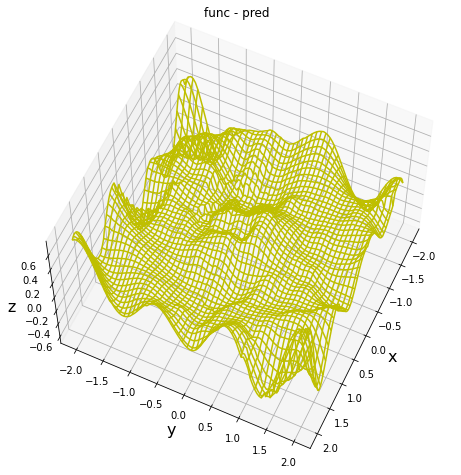

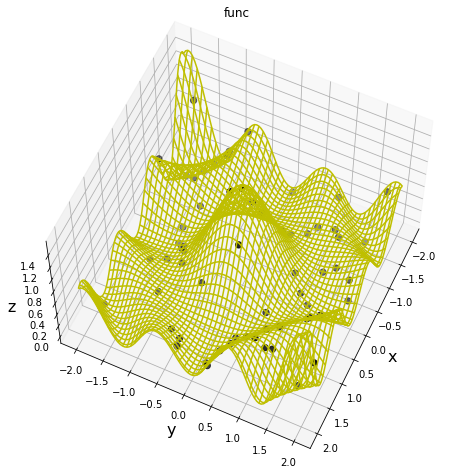

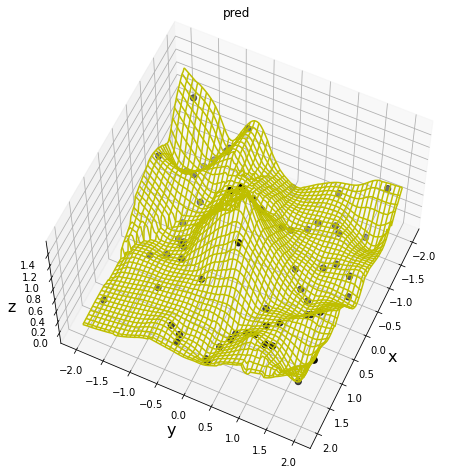

In [5]:
N1 = 8#とりあえず
n_trees = 4
N_data = 64

N3=10

def func(a, b):
    return 0.1*((a+b)**2+0.5*(a-b)**2)*(np.sin(a*b*0.4*np.pi))**2+1.5*np.exp(-2*(a**2+b**2))

np.random.seed(3211)
arrx = 4*np.random.rand(N_data,2) - 2*np.ones((N_data,2))
arry = func(arrx[:,0], arrx[:,1])

def poly_inv(dist):#dist=0で発散するので、fittingがtrainデータでは完全に一致
    #これを例えばガウシアンみたいにdist=0でも発散しない関数にするとtrainデータ点でも
    # 完全には一致しない(その代わりノイズに強くなると踏んでいる)
    return (dist)**(-4)

wai_test=wai_net(N1, arrx, arry, poly_inv, n_trees)

wai_test.learn(cand_rate=2, n_trial=20)


X = np.linspace(-2, 2, 100)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)
Z = np.zeros_like(X)
for x in range(100):
    for y in range(100):
        Z[x,y] = wai_test.infer(np.array([X[x,y], Y[x,y]]), N3)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("func - pred")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)
ax.plot_wireframe(X, Y, func(X,Y)-Z,color="y")

ax.view_init(elev=60, azim=25)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("func")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)
ax.plot_wireframe(X, Y, func(X,Y),color="y")

ax.scatter(arrx[:,0], arrx[:,1], arry, s=40, c="black")
ax.view_init(elev=60, azim=25)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("pred")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)

ax.scatter(arrx[:,0], arrx[:,1], arry, s=40, c="black")
ax.plot_wireframe(X, Y, Z,color="y")

ax.view_init(elev=60, azim=25)
plt.show()

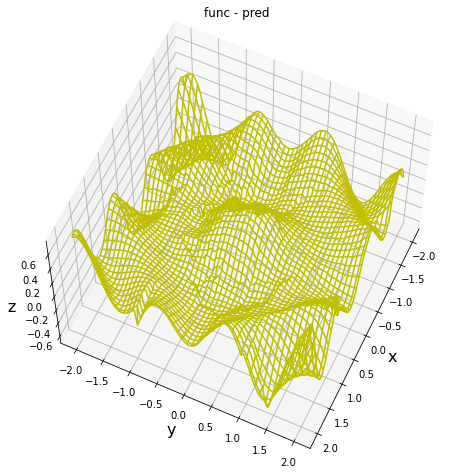

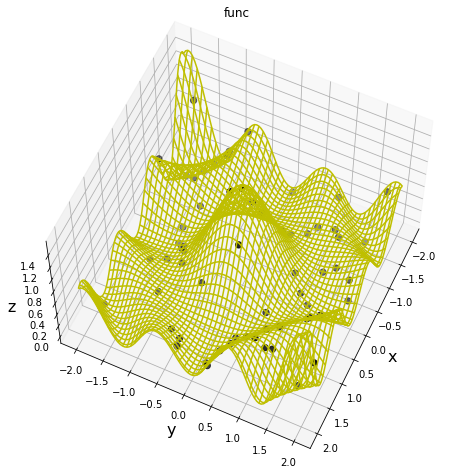

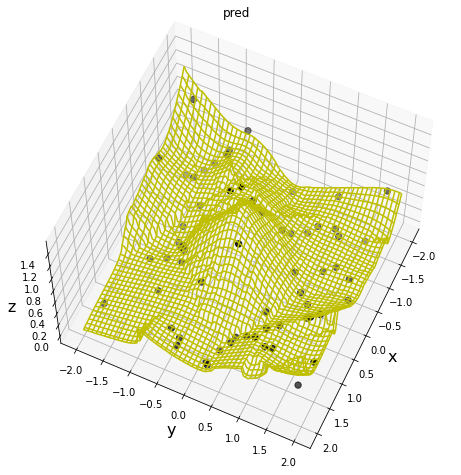

In [6]:
N1 = 8#とりあえず
n_trees = 4
N_data = 64

N3=10

def func(a, b):
    return 0.1*((a+b)**2+0.5*(a-b)**2)*(np.sin(a*b*0.4*np.pi))**2+1.5*np.exp(-2*(a**2+b**2))

np.random.seed(3211)
arrx = 4*np.random.rand(N_data,2) - 2*np.ones((N_data,2))
arry = func(arrx[:,0], arrx[:,1])

def gaussian(dist):
    return np.exp(-3*dist**2)

wai_test=wai_net(N1, arrx, arry, gaussian, n_trees)

wai_test.learn(cand_rate=2, n_trial=20)


X = np.linspace(-2, 2, 100)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)
Z = np.zeros_like(X)
for x in range(100):
    for y in range(100):
        Z[x,y] = wai_test.infer(np.array([X[x,y], Y[x,y]]), N3)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("func - pred")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)
ax.plot_wireframe(X, Y, func(X,Y)-Z,color="y")

ax.view_init(elev=60, azim=25)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("func")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)
ax.plot_wireframe(X, Y, func(X,Y),color="y")

ax.scatter(arrx[:,0], arrx[:,1], arry, s=40, c="black")
ax.view_init(elev=60, azim=25)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("pred")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)

ax.scatter(arrx[:,0], arrx[:,1], arry, s=40, c="black")
ax.plot_wireframe(X, Y, Z,color="y")

ax.view_init(elev=60, azim=25)
plt.show()

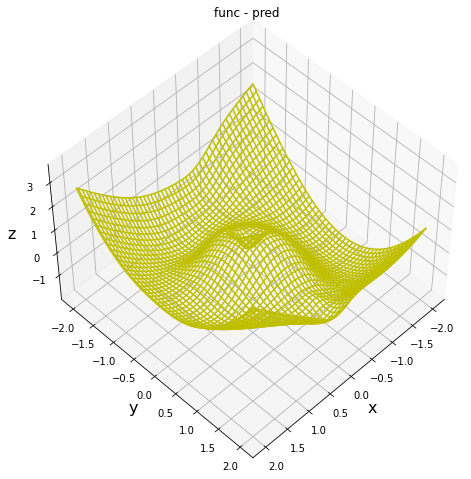

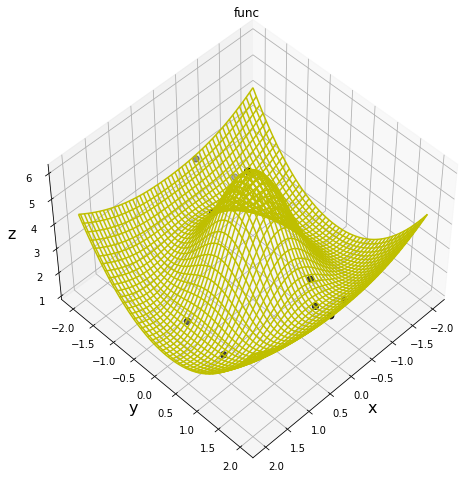

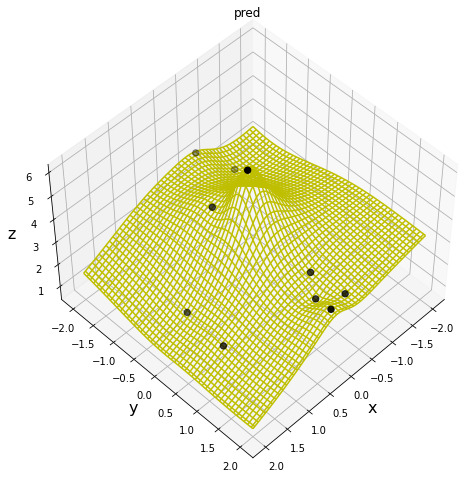

In [7]:
N1 = 6#とりあえず
n_trees = 4

N_data=10

def func(a, b):
    return 0.3*a**2 + 0.8*b**2 + 6*np.exp(-(a**2+b**2))

np.random.seed(1321)
arrx = 4*np.random.rand(N_data,2) - 2*np.ones((N_data,2))
arry = func(arrx[:,0], arrx[:,1])

def poly_inv(dist):
    return (dist)**(-2)

wai_test=wai_net(N1, arrx, arry, poly_inv, n_trees)

wai_test.learn(cand_rate=2, n_trial=20)

N3=10

X = np.linspace(-2, 2, 100)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)
Z = np.zeros_like(X)
for x in range(100):
    for y in range(100):
        Z[x,y] = wai_test.infer(np.array([X[x,y], Y[x,y]]), N3)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("func - pred")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)
ax.plot_wireframe(X, Y, func(X,Y)-Z,color="y")

ax.view_init(elev=50, azim=45)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("func")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)
ax.plot_wireframe(X, Y, func(X,Y),color="y")

ax.scatter(arrx[:,0], arrx[:,1], arry, s=40, c="black")

ax.view_init(elev=50, azim=45)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection="3d")
ax.set_title("pred")
ax.set_xlabel("x", size = 16)
ax.set_ylabel("y", size = 16)
ax.set_zlabel("z", size = 16)


ax.scatter(arrx[:,0], arrx[:,1], arry, s=40, c="black")
ax.plot_wireframe(X, Y, Z,color="y")

ax.view_init(elev=50, azim=45)
plt.show()

In [12]:
from sklearn.datasets import load_diabetes
import pandas as pd

data_diabetes = load_diabetes()

X_all = pd.DataFrame(data_diabetes["data"],columns=data_diabetes["feature_names"])
y_all = pd.DataFrame(data_diabetes["target"],columns=["target"])

X_all.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=44)

arrx = X_train.values
arry = y_train.values.reshape((len(y_train.values), ))
tesx_arr= X_test.values
tesy_arr = y_test.values.reshape((len(y_test.values), ))

N1 = 15#とりあえず
n_trees = 5
def gaussian(dist):
    return np.exp(-2*dist**2)

wai_test=wai_net(N1, arrx, arry, gaussian, n_trees)

wai_test.learn(cand_rate=2, n_trial=30)

In [29]:
N3=100
pred = np.array([wai_test.infer(tesx, N3) for tesx in tesx_arr])
np.corrcoef(np.stack([tesy_arr, pred]))#ビミョい。weightの定義を変えたら多少良くなる?

array([[1.        , 0.71904746],
       [0.71904746, 1.        ]])